In [1]:
import os
import sys
import torch
import random
import torchmetrics

sys.path.append(os.path.abspath(os.path.join(r'C:\Users\incognito\OneDrive\Desktop\PHD_UNM\DataMining\sesmicWaveClassification')))

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from models.cnn import CNN
from models.resnet import ResNet, PretrainedResNet
from models.loss import FocalLoss
from torchvision import transforms
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from torch.utils.data import DataLoader, TensorDataset
from utils.data_utils import count_unique_colum_and_vlaues, znorm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
train_features = np.load("../data/processed/balance_16k/model_input/train_features.npy")
train_labels = np.load("../data/processed/balance_16k/model_input/train_labels.npy")

test_features = np.load("../data/processed/balance_16k/model_input/test_features.npy")
test_labels = np.load("../data/processed/balance_16k/model_input/test_labels.npy")


In [4]:
train_features = torch.from_numpy(train_features).float()
train_features = train_features.to(device)
train_labels = torch.from_numpy(train_labels)
train_labels = train_labels.to(device)

test_features = torch.from_numpy(test_features).float()
test_features = test_features.to(device)
test_labels = torch.from_numpy(test_labels)
test_labels = test_labels.to(device)

In [5]:
# train_features = torch.nan_to_num(znorm(train_features))
# test_features = torch.nan_to_num(znorm(test_features))


In [6]:
print(train_features[0][0][0])

tensor([  753.9864,   136.9120,   142.2536,   193.8148,   679.0973,  1045.3160,
          208.0921,   660.0629,   602.3696,   466.4173,    44.9731,  1063.3285,
          983.5435,  1158.3901,  1317.0029,   292.3707,   417.9301,  1611.1099,
          565.4435,  1035.0190,   990.7064,  1756.8331,   317.0170,  2017.5638,
         5561.0454, 19579.4141, 10121.4854, 20266.6484,  9018.5918, 13965.2715,
         4714.4951,  3394.3601,  4501.1040,  5676.8320,  7213.4434,  3704.6299,
         6899.5938,  6471.7988,  2710.4446,   605.4897,   510.1440,   982.7007,
         1250.4010,   543.4738,  1140.0120,  3442.8403,   382.0093,  2034.4070,
         3507.3982,     0.0000], device='cuda:0')


In [7]:
print(f"Train features: {train_features.shape}, Train label: {train_labels.shape} ")
print(f"Test features: {test_features.shape}, Test label: {test_labels.shape} ")
train_min, train_max = train_features.min(), train_features.max()
print((train_min, train_max))

# inputs = 2 * (inputs - x_min) / (x_max - x_min) -1

Train features: torch.Size([29344, 3, 50, 50]), Train label: torch.Size([29344]) 
Test features: torch.Size([1631, 3, 50, 50]), Test label: torch.Size([1631]) 
(tensor(0., device='cuda:0'), tensor(21174082., device='cuda:0'))


In [8]:
unique_value, count = count_unique_colum_and_vlaues(test_labels.to(device='cpu'))
for x in range(len(count)):
    print(unique_value[x], count[x])

0 293
1 309
2 299
3 306
4 142
5 282


In [9]:
batch_size = 32
dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset)

In [10]:
# Hyperparameters

initial_lr = 1e-4
base_lr = 1e-4
warmup_steps = 30
epochs = 10

model = CNN()
model = model.to(device=device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = FocalLoss()
optimizer = optim.Rprop(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
model

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=373248, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [12]:
def train_model(
    model=model,
    dataloader=dataloader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=epochs,
    warmup_steps=warmup_steps,
    initial_lr=initial_lr,
    base_lr=base_lr,
):
    model = model.to(device=device)

    model.train()
    for epoch in range(epochs):
        if epoch < warmup_steps:
            lr = initial_lr + (base_lr - initial_lr) * (epoch / warmup_steps)
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        batch_loss = 0.0
        for batch_inputs, batch_targets in dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        avg_loss = batch_loss / len(dataloader)
        print(
            f"Epoch {epoch+1}/{epochs}, Cross Entropy Loss: {avg_loss:.4f}, Learning Rate: {initial_lr:.6f}"
        )

In [ ]:
train_model()

In [14]:
def calculate_accuracy_and_probabilities(model, dataloader, num_classes):
    model.eval()
    total_correct = 0
    total_samples = 0
    class_correct = torch.zeros(num_classes)
    class_samples = torch.zeros(num_classes)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            probs = F.softmax(outputs, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

            _, predictions = torch.max(outputs, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            for i in range(len(labels)):
                label = labels[i]
                if predictions[i] == label:
                    class_correct[label] += 1
                class_samples[label] += 1

    y_prob = torch.cat(all_probs, dim=0)
    y_true = torch.cat(all_labels, dim=0)

    total_accuracy = total_correct / total_samples * 100
    class_accuracy = class_correct / class_samples * 100

    return total_accuracy, class_accuracy, y_prob, y_true


num_classes = 6
total_accuracy, class_accuracy, y_prob, y_true = calculate_accuracy_and_probabilities(
    model, dataloader=test_dataloader, num_classes=num_classes
)

print(f"Total Accuracy: {total_accuracy:.2f}%")
for i in range(num_classes):
    print(f"Accuracy of class {i}: {class_accuracy[i]:.2f}%")

Total Accuracy: 72.78%
Accuracy of class 0: 72.01%
Accuracy of class 1: 87.70%
Accuracy of class 2: 76.59%
Accuracy of class 3: 65.69%
Accuracy of class 4: 52.82%
Accuracy of class 5: 70.92%


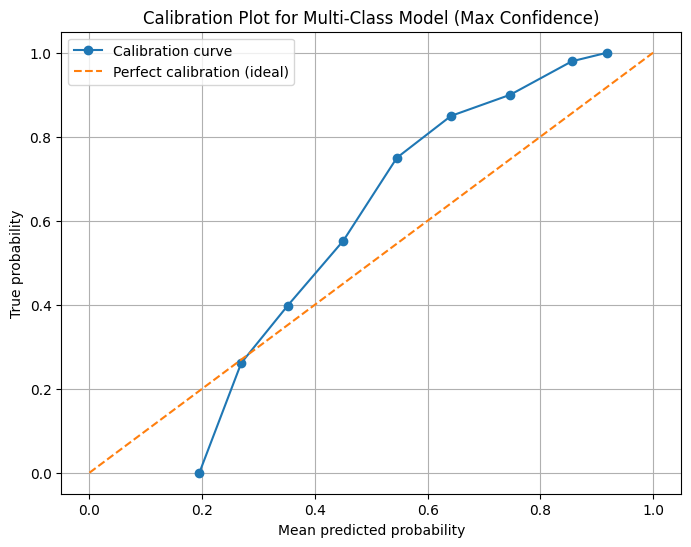

Brier score loss: 0.2135


In [15]:
def plot_calibration_curve(y_true, y_prob, n_bins=10):
    y_true_np = y_true.cpu().numpy()
    y_prob_np = y_prob.cpu().detach().numpy()

    y_prob_max = np.max(y_prob_np, axis=1)

    y_pred_max = np.argmax(y_prob_np, axis=1)

    prob_true, prob_pred = calibration_curve(
        y_true_np == y_pred_max, y_prob_max, n_bins=n_bins
    )

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker="o", label="Calibration curve")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration (ideal)")

    plt.title("Calibration Plot for Multi-Class Model (Max Confidence)")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("True probability")
    plt.legend()
    plt.grid(True)
    plt.show()

    brier_score = brier_score_loss(y_true_np == y_pred_max, y_prob_max)
    print(f"Brier score loss: {brier_score:.4f}")


plot_calibration_curve(y_true, y_prob)

In [16]:
# model.eval()

# test_dataset = TensorDataset(test_features, test_labels)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=6).to(device)

# with torch.no_grad():
#     for batch_test_inputs, batch_test_targets in test_dataloader:
#         outputs = model(batch_test_inputs)
#         predictions = torch.argmax(outputs, dim=1)
#         accuracy.update(predictions, batch_test_targets)

# final_accuracy = accuracy.compute().item()
# print(f"Accuracy on the test data: {final_accuracy * 100:.2f}%")

# accuracy.reset()


# def lr_finder(model, criterion, optimizer, train_loader, init_value=1e-10, final_value=10, beta=0.98):
#     num = len(train_loader) - 1
#     mult = (final_value / init_value) ** (1/num)
#     lr = init_value
#     optimizer.param_groups[0]['lr'] = lr
#     avg_loss, best_loss = 0.0, 0.0
#     losses, log_lrs = [], []

#     for i, (inputs, labels) in enumerate(train_loader):
#         # Move data to the correct device
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Compute the smoothed loss
#         avg_loss = beta * avg_loss + (1 - beta) * loss.item()
#         smoothed_loss = avg_loss / (1 - beta ** (i + 1))

#         # Stop if the loss is exploding
#         if i > 1 and smoothed_loss > 4 * best_loss:
#             break

#         # Record the best loss
#         if smoothed_loss < best_loss or i == 0:
#             best_loss = smoothed_loss

#         # Backward pass and update the weights
#         loss.backward()
#         optimizer.step()

#         # Store the values
#         losses.append(smoothed_loss)
#         log_lrs.append(lr)

#         # Update the learning rate
#         lr *= mult
#         optimizer.param_groups[0]['lr'] = lr

#     # Plot the learning rate vs loss graph
#     plt.plot(log_lrs, losses)
#     plt.xscale('log')
#     plt.xlabel("Learning Rate")
#     plt.ylabel("Loss")
#     plt.show()

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-8)

# lr_finder(model, criterion, optimizer, dataloader)